In [ ]:
!pip install faker

In [16]:
from IPython.display import clear_output
import sqlite3
from contextlib import closing
from datetime import datetime
from tqdm import tqdm

print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:54.944245


In [17]:
def select_data(db_file_path, db_data, reverse=False, verbose=0):
    """ select_data """
    with closing(sqlite3.connect(db_file_path)) as conn:
        with closing(conn.cursor()) as cur:
            col_dicts = {"n_estimator": (db_data[1], True),
                         "data_length": (db_data[2], True),
                         "random_state": (db_data[3], True),
                         "rounds": (db_data[4], False)
                         }
            where_list = []
            for col in col_dicts:
                if col_dicts[col][1]:
                    where_list.append(f'{col}={col_dicts[col][0]}')
                else:
                    where_list.append(f'{col}=\"{col_dicts[col][0]}\"')
            results = []
            query = f'select * from rndforest where {" and ".join(where_list)}'
            query += " order by id desc" if reverse else " order by id asc"
            if verbose > 0:
                print('query=', query)
            datas = cur.execute(query).fetchall()
            for data in datas:
                results.append(data)
            return results


def insert_data(db_file_path, db_data, auto_commit=True, verbose=0):
    """ insert_randomforest_db """
    with closing(sqlite3.connect(db_file_path)) as conn:
        col_dicts = {"n_estimator": db_data[1],
                     "data_length": db_data[2],
                     "random_state": db_data[3],
                     "rounds": db_data[4],
                     "matched_cnts": db_data[5],
                     "sum_val": db_data[6],
                     "version": db_data[7]+"_back"
                     }
        columns = col_dicts.keys()
        values=list(col_dicts.values())
        column_val=["?" for i in range(len(columns))]
        query = f"INSERT INTO rndforest ({','.join(columns)}) "\
        f"VALUES ({','.join(column_val)})"
        with closing(conn.cursor()) as cursor:
            if verbose > 0:
                print(f'query={query}')
                print('-'*30)
            cursor.execute(query, values)
            if auto_commit:
                conn.commit()


def backup_randomforest_db(db_file_path, db_datas, auto_commit=True, verbose=0):
    for db_data in db_datas:
        if verbose > 0:
            print('db_data = ', db_data)
        result = select_data(db_file_path, db_data, verbose=verbose)
        if len(result) == 0:
            insert_data(db_file_path, db_data, verbose=verbose)

print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:55.356430


In [18]:
def db_row_parse(rows):
    """ db_row_parse """
    rows_list = []
    for row in rows:
        cols = row.split('|')
        col_dict = {
            "n_estimator": cols[1],
            "data_length": cols[2],
            "random_state": cols[3],
            "rounds": cols[4],
            "matched_cnts": cols[5],
            "sum_val": cols[6],
            "version": cols[7]
            }
        rows_list.append(col_dict)
    return rows_list


def execute_direct_query_for_sum_val_frequency(min_cnt, max_cnt, target_num, version, verbose=0):
    """ execute_direct_query_for_sum_val_frequency """
    likes = ""
    results = {}
    ## base
    for i in range(1, min_cnt):
        likes += f"%{target_num}"
    for i in range(min_cnt, max_cnt+1):
        likes += f"%{target_num}"
        if verbose > 0:
            !echo "{'-'*15} {target_num}'s num = {i} {'-'*15}"
        if verbose > 0:
            !echo "select * from rndforest where version=\"{version}\" and matched_cnts like \"{likes}%\" order by sum_val desc"
        rows = !echo "select * from rndforest where version=\"{version}\" and matched_cnts like \"{likes}%\" order by sum_val desc" | sqlite3 ../db/metrics.db
        rows_list = db_row_parse(rows)
        results[i] = rows_list
    return results


def print_colums(target_num, results, list_view=False):
    """ print_colums """
    for cnt in results:
        print(f"{'-'*15} {target_num}'s num = {cnt} {'-'*15}")
        for row in results[cnt]:
            if list_view:
                print(list(row.values()))
            else:
                print(row)


def db_query(min_cnt, max_cnt, target_num, version, print_data=False, list_view=False, verbose=0):
    """ db_query """
    results = execute_direct_query_for_sum_val_frequency(min_cnt=min_cnt, max_cnt=max_cnt, target_num=target_num, version=version, verbose=verbose)
    if print_data:
        print_colums(target_num, results, list_view)
    return results


print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:56.063084


In [19]:
def subprocess_v2(cmd_list1, cmd_list2):
    """ subprocess_v2 """
    process1 = subprocess.Popen(cmd_list1, stdout=subprocess.PIPE)
    process2 = subprocess.Popen(cmd_list2, stdin=process1.stdout, stdout=subprocess.PIPE)
    output, error = process2.communicate()
    if error:
        print(f"Error: {error.decode('utf-8')}")
        return ""
    lines = output.decode('utf-8').split('\n')
    results = []
    for line in lines:
        if len(line) > 0:
            results.append(line)
    return results


def db_dicret_query(query, db_file_path) -> list:
    """ db_dicret_query             """
    """ sqlite3에 바로 sql을 실행합니다. """
    sql_parts = ['echo', query]
    execute_parts = ['sqlite3', db_file_path]
    rows = subprocess_v2(sql_parts, execute_parts)
    data_cols = []
    for row in rows:
        if len(row) > 0:
            cols = row.split('|')
            data_cols.append(row.split('|'))
    return data_cols
    

execute_example=False
if execute_example:
    query = 'select * from rndforest where version=\"T_01_02\" and sum_val > 7;'
    db_file_path = '../db/metrics.db'
    data_cols = db_dicret_query(query=query, db_file_path=db_file_path)
    for data_col in data_cols:
        print(data_col)

print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:56.980340


In [20]:
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
from faker import Factory

def draw_datas_graph(title,
                     x_y_datas,
                     x_label,
                     y_label,
                     width=0,
                     height=0,
                     file_name="",
                     is_bar=True,
                     verb=False):
    """ draw_data_graph """
    fake = Factory.create()
    for x_y_data in x_y_datas:
        if is_bar:
            if len(x_y_data) > 2:
                plt.bar(x_y_data[0], x_y_data[1], color=fake.hex_color(), label=x_y_data[2])
            else:
                plt.bar(x_y_data[0], x_y_data[1], color=fake.hex_color())
        else:
            if len(x_y_data) > 2:
                plt.plot(x_y_data[0], x_y_data[1], color=fake.hex_color(), label=x_y_data[2])
            else:
                plt.plot(x_y_data[0], x_y_data[1], color=fake.hex_color())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.title(title)
    if len(file_name) > 0:
        plt.legend(loc=0)
        plt.savefig(file_name)
    if width > 0 and height > 0:
        plt.figure(figsize=(width,height))
    plt.show()

print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:57.526891


In [21]:
def data_graph_from_db(version: str, random_states: list, verbose=0):
    """ data_graph_from_db """
    DB_FILE="../db/metrics.db"

    if len(random_states) == 0:
        wheres = ""
    else:
        temp = [str(i) for i in random_states]
        wheres = f'and random_state in ({",".join(temp)})'
    rows = !echo "select * from rndforest where version=\"{version}\" {wheres} order by random_state asc" | sqlite3 {DB_FILE}

    if len(rows) > 0:
        x_y_datas = []
        for row in rows:
            cols = row.split("|")
            n_estimator = cols[1]
            data_length = cols[2]
            random_state = cols[3]
            rounds = [int(i) for i in cols[4].split(',')]
            matched_cnts = [int(i) for i in cols[5].split(',')]
            rounds.reverse()
            matched_cnts.reverse()
            sum_val = cols[6]
            x_y_datas.append((rounds, matched_cnts, str(random_state)))
            # print(f'{n_estimator} / {data_length} / {random_state} / {sum_val}')
            if verbose > 0:
                print('rounds', rounds)
                print('matched_cnts', matched_cnts)

        # ## predict data
        # file_name = "img/temp.png"
        draw_datas_graph(title="matched_cnts",
                         x_y_datas=x_y_datas,
                         x_label="rounds",
                         y_label="matched_cnts",
                         width=0,
                         height=0,
                         file_name="",
                         is_bar=False,
                         verb=False if verbose == 0 else True)
    return len(rows)

print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:57:59.725248


In [22]:
def check_yes(title, wanted: list, default: str):
    """ check_yes """
    is_continue_str = input(title)
    if len(is_continue_str) == 0:
        is_continue_str = default
    if is_continue_str in wanted:
        return True
    return False


def check_continue():
    """ check_conotinue """
    return check_yes("Continue ? (Y/n)", ["Y", "y"], "y")


def check_append_to_list():
    """ check_conotinue """
    return check_yes("Append to list ? (Y/n)", ["Y", "y"], "n")


def check_reset_list():
    """ check_conotinue """
    return check_yes("Reset list ? (Y/n)", ["Y", "y"], "n")


def check_remove_this(value):
    """ check_remove_this """
    return check_yes(f"Remove this({value}) ? (Y/n)", ["Y", "y"], "n")


def get_wanted_item(title) -> list:
    """ get_wanted_item """
    wanted_line = input(title)
    if len(wanted_line) > 0:
        return wanted_line.split(",")
    return []


print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:58:00.624916


In [24]:
version='T_01_13'
t_version='T_01_95'
print(f'define this code : [now={datetime.now()}')

define this code : [now=2025-06-23 12:58:09.331447


In [ ]:
!echo "select * from rndforest where version=\"{t_version}\" and matched_cnts like '%3%3%3%3%3%';" | sqlite3 ../db/metrics.db

In [10]:
# 3이 많이 발생하는 경우 확인
min_cnt = 0
max_cnt = 7
target_num = 3
results3_T01_08 = db_query(min_cnt=min_cnt, max_cnt=max_cnt, version=version, target_num=target_num, print_data=True, list_view=True)

--------------- 3's num = 0 ---------------
--------------- 3's num = 1 ---------------
--------------- 3's num = 2 ---------------
--------------- 3's num = 3 ---------------
--------------- 3's num = 4 ---------------
--------------- 3's num = 5 ---------------
--------------- 3's num = 6 ---------------
--------------- 3's num = 7 ---------------


In [ ]:
# 4가 많이 발생하는 경우 확인
min_cnt = 2
max_cnt = 7
target_num = 4
versions = [version]
results_dict4 = {}
for ver in versions:
    print(f'\n{"*"*15} Checking version = [{ver}] {"*"*15}\n')
    results = db_query(min_cnt=min_cnt, max_cnt=max_cnt, version=version, target_num=target_num, print_data=True, list_view=True)
    results_dict4[ver] = results

In [64]:
# 5/6이 많이 발생하는 경우 확인
min_cnt = 1
max_cnt = 3
target_nums = [5, 6]
versions = [version]
results_dict5 = {}
for ver in versions:
    results_dict5[version] = {}
    for target_num in target_nums:
        print(f'\n{"*"*15} Checking version = [{ver} / {target_num}] {"*"*15}\n')
        results = db_query(min_cnt=min_cnt,
                           max_cnt=max_cnt,
                           version=version,
                           target_num=target_num,
                           print_data=True,
                           list_view=True)
        results_dict5[ver][target_num] = results


*************** Checking version = [T_01_12 / 5] ***************

--------------- 5's num = 1 ---------------
['100', '100', '3702', '1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,

In [ ]:
min_rnd_st=113400
max_rnd_st=113830
from datetime import datetime
print(version)
query = f'select * from rndforest where version=\\"{version}\\" and random_state>={min_rnd_st} and random_state<{max_rnd_st};'
print(query)
rows = !echo "{query}"|sqlite3 ../db/metrics_or.db
matched_cnts_3 = []
print(datetime.now(), rows)
for row in rows:
    print(row)
    cols = row.split('|')
    matched_cnts = cols[5].split(',')
    count = 0;
    for mc in matched_cnts:
        if int(mc) > 2:
            count+=1
    matched_cnts_3.append((cols[0], cols[3], count))
sorted_data = sorted(matched_cnts_3, key=lambda x: x[2])
for data in sorted_data:
    print(data)

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176]
!echo "select * from rndforest where version=\"T_01_03\" and sum_val > 14;" | sqlite3 ../db/metrics.db
!echo "...........like 4.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%4%\";" | sqlite3 ../db/metrics.db
!echo "...........like 5.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%5%\";" | sqlite3 ../db/metrics.db
!echo "...........like 6.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%6%\";" | sqlite3 ../db/metrics.db
!echo "..............................................."
!echo "select * from rndforest where version in (\"T_01_07\", \"T_01_03\") and sum_val > 13;" | sqlite3 ../db/metrics.db
!echo "..............................................."


In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176]
version="T_01_05"
!echo "select * from rndforest where version=\"T_01_03\" and random_state in (357, 264, 762, 864);" | sqlite3 ../db/metrics.db
!echo "select * from rndforest where version=\"T_01_06\" and sum_val > 2;" | sqlite3 ../db/metrics.db

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175]
version="T_01_05"
!echo "select * from rndforest where version=\"T_01_05\" and sum_val > 3;" | sqlite3 ../db/metrics.db

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175, 1174]
!echo "select * from rndforest where version=\"T_01_04\" and sum_val > 5;" | sqlite3 ../db/metrics.db

In [226]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175, 1174, 1173]
!echo "select * from rndforest where version=\"T_01_02\" and sum_val > 7;" | sqlite3 ../db/metrics.db
db_file_path = '../db/metrics.db'
version = "T_01_02"
query = f'select * from rndforest where version=\"{version}\" and sum_val > 7;'
db_dicret_query(query=query, db_file_path=db_file_path)

8517|25|40|430|1176,1175,1174,1173|2,1,1,4|8|T_01_02
10170|10|40|129|1176,1175,1174,1173|2,2,2,2|8|T_01_02


[['8517', '25', '40', '430', '1176,1175,1174,1173', '2,1,1,4', '8', 'T_01_02'],
 ['10170',
  '10',
  '40',
  '129',
  '1176,1175,1174,1173',
  '2,2,2,2',
  '8',
  'T_01_02']]

In [ ]:
old_versions = ["T_01_01", "T_01_02", "T_01_03", "T_01_04", "T_01_05"]
sum_val = 7
for version in old_versions:
    !echo "select * from rndforest where version=\"{version}\" and sum_val > {sum_val};" | sqlite3 ../db/metrics.db

In [ ]:
!echo "select * from rndforest where version=\"T_01_03\" and random_state=762;" | sqlite3 ../db/metrics.db
!echo "........................................."
!echo "select * from rndforest where version=\"T_01_03\" and sum_val > 12;" | sqlite3 ../db/metrics.db

## 1. __N개 씩 데이터를 읽어서 화면에 표시합니다.__

### 1.1 글로벌 변수 정의

In [10]:
## - 데이터 보존을 위하여 여기에서 정의합니다.
answer_list = []
first = 113700
last = 113800
step = 10

In [25]:
# for i in ['113686', '113700', '113708', '113738', '113746', '113750', '113755', '113759', '113765', '113776', '113783', '113789', '113792', '113794', '113795']:
#     answer_list.append(int(i))

### 1.2 데이터 확인 (N개 씩)

first random_state is 113700 / first
last random_state is 113902 / last
first 113700
last 113702
step 10


처음을 입력하세요: (ex: 113700) 113700
마지막을 입력하세요: (ex: 113702) 113702
step을 입력하세요: (ex: 10) 2


  0%|          | 0/1 [00:00<?, ?it/s]

마지막 데이터 입니다.
113700 113702
random_states = [113700, 113701]


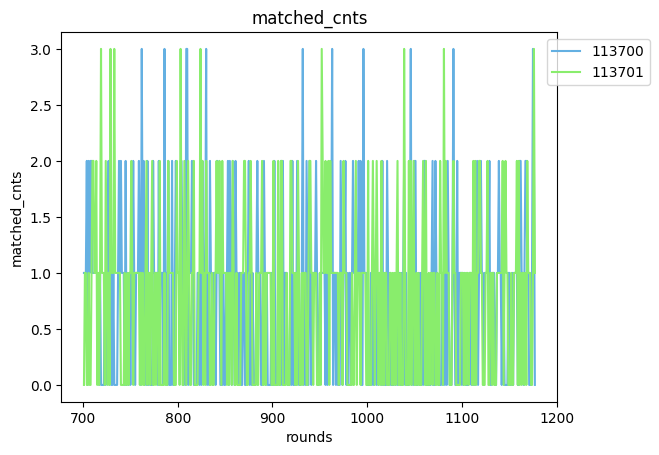

저장할 번호를 선택하세요. (","로 분리하세요) 


100%|██████████| 1/1 [00:34<00:00, 34.09s/it]


In [25]:
T_VERSION=t_version
db_path='../db/metrics.db'

first_random_state = !echo 'select random_state from rndforest where version="{T_VERSION}" order by random_state limit 1' | sqlite3 {db_path}
last_random_state = !echo 'select random_state from rndforest where version="{T_VERSION}" order by random_state desc limit 1' | sqlite3 {db_path}
print(f'first random_state is {first_random_state[0]} / first')
print(f'last random_state is {last_random_state[0]} / last')

try:
    print('first', first)
except NameError as ex:
    first = 1000

try:
    print('last', last)
except NameError as ex:
    last = 10

try:
    print('step', step)
except NameError as ex:
    step = 10


first_str = input(f"처음을 입력하세요: (ex: {first})")
if len(first_str) > 0:
    first = int(first_str)
else:
    first = int(first_random_state[0])
last_str = input(f"마지막을 입력하세요: (ex: {last})")
if len(last_str) > 0:
    last = int(last_str)
else:
    last = int(last_random_state[0])

step_str = input(f"step을 입력하세요: (ex: {step})")
if len(step_str) > 0:
    step = int(step_str)
else:
    step = 10

for current in tqdm(range(first, last, step)):
    # %matplotlib inline
    is_last_data = False
    begin = current
    end = current + step
    if end >= last:
        end = last
        print('마지막 데이터 입니다.')
        is_last_data = True
    print(begin, end)
    random_states = [i for i in range(begin, end, 1)]
    print(f'random_states = {random_states}')
    row_len = data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)
    if row_len > 0:
        wanted_items = get_wanted_item('저장할 번호를 선택하세요. (","로 분리하세요)')
        for random_state in wanted_items:
            if random_state not in answer_list:
                answer_list.append(random_state)
        if is_last_data == False:
            is_continue = check_continue()
            if is_continue == False:
                break
            else:
                clear_output()
    else:
        print('Have no more data.')
        break

In [18]:
print(f'first = {first}')
print(f'end   = {end}')
print(f'step  = {step}')
print(f'selected = {answer_list}')

first = 113800
end   = 113852
step  = 2
selected = ['113808', '113811', '113812', '113813', '113818', '113820', '113822', '113826', '113831', '113833', '113834', '113837', '113838', '113841', '113842', '113844', '113846', '113847', '113850']


### 1.3 위에서 저장한 random_state를 그래프로 확인 함.

 96%|█████████▌| 22/23 [00:44<00:00,  1.23it/s]

selected random_state :  113794


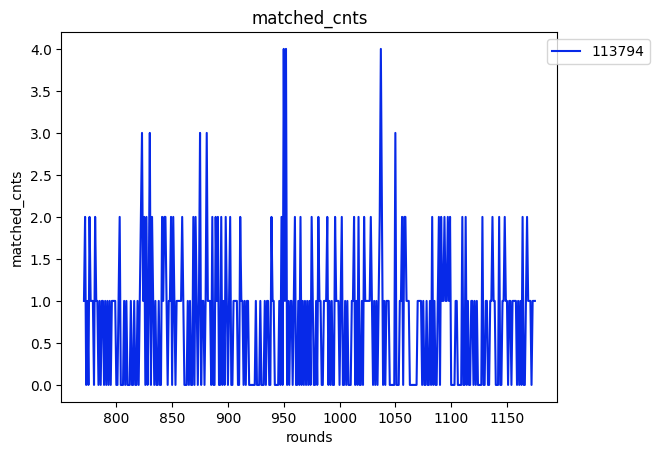

Remove this(113794) ? (Y/n) 


100%|██████████| 23/23 [00:44<00:00,  1.95s/it]


In [265]:
print(f'{"="*30}')
answer_list.sort()
temp_list = answer_list
for random_state in tqdm(temp_list):
    if temp_list[len(temp_list)-1] == random_state:
        is_last_data = True
    else:
        is_last_data = False
    print('selected random_state : ', random_state)
    data_graph_from_db(version=T_VERSION, random_states=[random_state],verbose=0)
    is_remove_this = check_remove_this(random_state)
    if is_remove_this:
        answer_list.remove(random_state)
    if is_last_data == False:
        is_continue = check_conotinue()
        if is_continue == False:
            break
        else:
            clear_output()

In [ ]:
# temp = []
# for i in answer_list:
#     print(i, type(i))
#     if isinstance(i, str):
#         temp.append(int(i))
#     else:
#         temp.append(i)
# temp.sort()
# answer_list = temp

In [248]:
print(f'first = {first}')
print(f'end   = {end}')
print(f'step  = {step}')
print(f'selected = {answer_list}')

first = 113400
end   = 113450
step  = 2
selected = [113686, 113700, 113708, 113738, 113746, 113755, 113759, 113765, 113783, 113789, 113794, '113400', '113404', '113408', '113410', '113423', '113430', '113433', '113438', '113440']


## 2. __위에서 선택 된 데이터에 대해서 한 번 더 그래프를 확인 합니다.__

### 2.1 특정 데이터에 대해서 확인을 합니다.

 92%|████████████████████████████████████████████████████████████████████████████▌      | 12/13 [02:06<00:07,  7.15s/it]

random_state = 3792


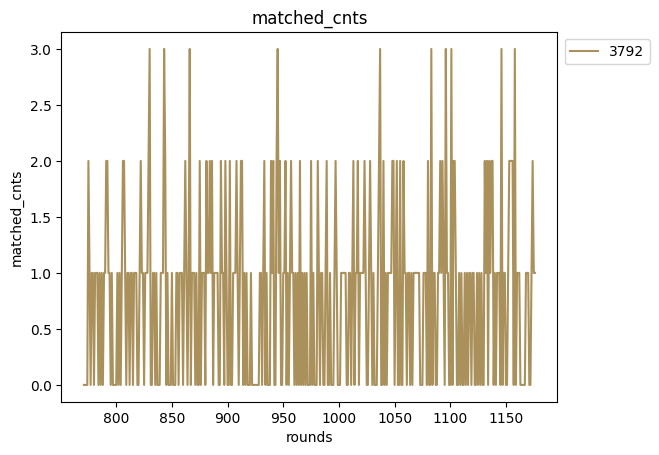

100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [02:06<00:00,  9.73s/it]


In [72]:
# random_states = [114001, 114003, 114005, ]
# random_states = [114005, ]
# random_states = [113723, 113732, 113738]
# 113791, 113798
# 113661
# 113797
# random_states = [113700, 113738, 113696, 113745, 113789]
# random_states = [113410, 113732, 113429, 113650, 113424, 113837]
# random_states = [113410, 113732, 113429, 113658, 113650, 113424, 113837]
"""
('74698', '3711', 11)
('74715', '3728', 11)
('74716', '3729', 11)
('74730', '3743', 11)
('74722', '3735', 12)
('74696', '3709', 13)
('74699', '3712', 13)
('74711', '3724', 13)
('74723', '3736', 13)
('74729', '3742', 13)
('74720', '3733', 14)

74720
"""

random_states = []
data_rows_str="\
('74698', '3711', 11)\
('74715', '3728', 11)\
('74716', '3729', 11)\
('74730', '3743', 11)\
('74746', '3759', 11)\
('74778', '3791', 11)\
('74781', '3794', 11)\
('74722', '3735', 12)\
('74766', '3779', 12)\
('74767', '3780', 12)\
('74696', '3709', 13)\
('74699', '3712', 13)\
('74711', '3724', 13)\
('74723', '3736', 13)\
('74729', '3742', 13)\
('74720', '3733', 14)\
"
rows_str="\
('74691', '3704', 9)\
('74708', '3721', 9)\
('74709', '3722', 9)\
('74717', '3730', 9)\
('74718', '3731', 9)\
('74719', '3732', 9)\
('74741', '3754', 9)\
('74749', '3762', 9)\
('74760', '3773', 9)\
('74764', '3777', 9)\
('74772', '3785', 9)\
('74774', '3787', 9)\
"
rows_str="\
('74713', '3726', 8)\
('74724', '3737', 8)\
('74734', '3747', 8)\
('74737', '3750', 8)\
('74747', '3760', 8)\
('74752', '3765', 8)\
('74755', '3768', 8)\
('74758', '3771', 8)\
('74765', '3778', 8)\
('74773', '3786', 8)\
"

rows_str="\
('74689', '3702', 10)\
('74692', '3705', 10)\
('74702', '3715', 10)\
('74704', '3717', 10)\
('74712', '3725', 10)\
('74721', '3734', 10)\
('74740', '3753', 10)\
('74743', '3756', 10)\
('74748', '3761', 10)\
('74757', '3770', 10)\
('74775', '3788', 10)\
('74777', '3790', 10)\
('74779', '3792', 10)\
"
rows_str = rows_str.replace("(","")
rows = rows_str.split(")")
for row in rows:
    if len(row) > 0:
        row = row.replace("\'","")
        cols = row.split(", ")
        if len(cols) > 0:
            print(cols)
            random_states.append(int(cols[1]))
print(random_states)

for random_state in tqdm(random_states):
    print(f'random_state = {random_state}')
    if random_state == random_states[len(random_states) - 1]:
        is_last = True
    else:
        is_last = False
    data_graph_from_db(version=version, random_states=[random_state],verbose=0)
    if is_last == False:
        is_continue = check_continue()
        if is_continue == False:
            break
        else:
            clear_output()

## 3. __한 개의 데이터 만을 확인 합니다.__

In [ ]:
3731,3786,3702,3715,3734,3753,3761,3770

random_state를 ","로 구분하여 입력하여 주세요. 113806


  0%|          | 0/1 [00:00<?, ?it/s]

random_state = 113806


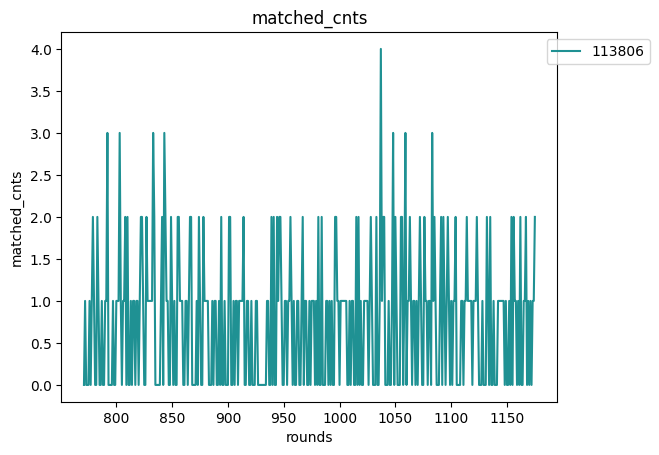

100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


In [26]:
T_VERSION="T_01_10"

random_states = get_wanted_item('random_state를 ","로 구분하여 입력하여 주세요.')

for random_state in tqdm(random_states):
    print(f'random_state = {random_state}')
    if random_state == random_states[len(random_states) - 1]:
        is_last = True
    else:
        is_last = False
    data_graph_from_db(version=T_VERSION, random_states=[random_state],verbose=0)
    if is_last == False:
        is_continue = check_conotinue()
        if is_continue == False:
            break
        else:
            clear_output()

```
create table rndforest_possi(id INTEGER PRIMARY KEY AUTOINCREMENT, version TEXT, random_state INTEGER, possibility FLOAT);
create table rndforest_possi(id INTEGER PRIMARY KEY AUTOINCREMENT, version TEXT, random_state INTEGER, possibility FLOAT, max INTEGER);
```

In [ ]:
157|T_01_11|113410|2.05857292|4.0
14|T_01_11|113732|2.03060084581375|4.999999998
159|T_01_11|113429|2.01577738|4.0
155|T_01_11|113658|1.90289810299873|4.0
147|T_01_11|113650|1.76873996853828|4.0
158|T_01_11|113424|1.74410105|4.0
74|T_01_11|113837|1.74028784036636|4.0


[113410, 113732, 113429, 113658, 113650, 113424, 113837]